# Import packages

In [33]:
import torch
import torch.nn as nn
import torchdiffeq
from torchdiffeq import odeint
from xitorch.interpolate import Interp1D
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

# Define classes for parameter-container and sequence generator

In [34]:
"""
Class RateStateParams, manages data of rate-and-state friction with flash-heating effect, contains 
    Data:
        fr: Reference friction coefficient
        a: Rate-and-state parameter a
        b: Rate-and-state parameter b
        DRS: Characteristic slip distance
        Vw: Flash-heating slip rate
        fw: Flash-heating friction coefficient
"""
class RateStateParams:
    # Constructor
    def __init__(self, fr = 0.6, Vr = 1.e-6, a = 0.016, b = 0.011, DRS = 1.e-6, Vw = 1.0e6, fw = 0.2):
        self.fr = fr
        self.Vr = Vr
        self.a = a
        self.b = b
        self.DRS = DRS
        self.Vw = Vw
        self.fw = fw
        
    # Output the information of this class
    def print_info(self):
        print("-" * 20, " Rate-and-state parameters ", "-"*20)
        print('fr:       ', self.fr)
        print('a:        ', self.a)
        print('b:        ', self.b)
        print('Vr:       ', self.Vr)
        print('DRS:      ', self.DRS)
        print('Vw:       ', self.Vw)
        print('fw:       ', self.fw)
        

In [35]:
"""
Class TimeSequenceGen, container for a Generated time sequence containing 
    Data:
        t [number of time points]: Tensor for time stamps, prescribed
        N [number of time points]: Tensor for normal stress, prescribed
        Ds [number of time points]: Tensor for slip rate, prescribed
        s [number of time points]: Tensor for slip, prescribed
        theta [number of hidden variables, number of time points]: Tensor for hidden variables, computed
        params : Class for parameters
    Method:
        __init__ : Constructor
        DthetaDt : Evolution function for hidden variables theta
        calTau : Calculate the function of shear stress Tau
"""
class TimeSequenceGen:
    # Constructor
    def __init__(self, t, N, Ds, params):
        # Load the parameters
        self.t = t
        self.N = N
        self.Ds = Ds
        self.s = torch.zeros(Ds.shape, dtype = torch.float64)
        self.s[1:] = torch.cumulative_trapezoid(Ds, x = t)
        self.params = params
        
        # Calculate theta history
        self.theta = torch.zeros(Ds.shape, dtype = torch.float64)
        
        # Compute the interpolation for slip rate Ds
        self.t_temp = torch.concat([self.t, torch.tensor([self.t[-1] + 1.0e-4])], 0)
        self.Ds_temp = torch.concat([self.Ds, torch.tensor([self.Ds[-1]])], 0)
        self.DsAtT = interp1d(self.t_temp, self.Ds_temp, kind="cubic")
        
        # Evolve theta(t)
        self.theta = self.calTheta()
        
        # Finish computing tau
        self.tau = self.calTau()
    
    # Function DthetaDt, defines DthetaDt as a function of temporally local values
    def DthetaDt(self, t, theta):
        # print('t = ', t)
        DthetaDt = (1. - torch.tensor(self.DsAtT(t)) * theta) / self.params.DRS
        return DthetaDt
    
    # Function calTau, calculates shear traction tau, suingregularized rate-and-state formulation
    def calTau(self):
        # Set aliases for rate-and-state parameters
        a = self.params.a
        b = self.params.b
        Vr = self.params.Vr
        DRS = self.params.DRS
        fr = self.params.fr
        
        tau = self.N * a * torch.asinh(
                   self.Ds / 2. / Vr * torch.exp((fr + b * torch.log(Vr * self.theta / DRS)) / a)
                   )
        return tau
    
    # Calculate theta using s(t), Ds(t), theta(t) and params
    def calTheta(self, theta0 = torch.tensor(1.0)):
        theta = odeint(self.DthetaDt, theta0, self.t)
        return theta


# Demo: given $N(t)$ and $V(t)$, generate $\theta(t)$ and $\tau(t)$

In [36]:
# Set parameters
myRSParams = RateStateParams()
myRSParams.print_info()

--------------------  Rate-and-state parameters  --------------------
fr:        0.6
a:         0.016
b:         0.011
Vr:        1e-06
DRS:       1e-06
Vw:        1000000.0
fw:        0.2


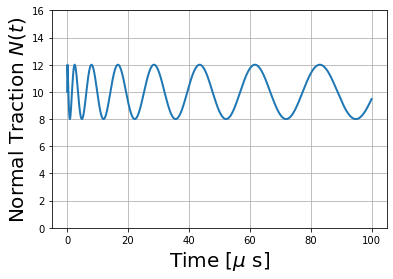

In [37]:
# Set t [s], N(t) [MPa]
t = torch.linspace(0., 100., 10000, dtype=torch.float64) * 1.0e-6
N = torch.ones(t.shape, dtype=torch.float64) * 10 + 2 * torch.sin(5 * torch.sqrt(1.e6 * t))
plt.plot(1e6 * t, N, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('Normal Traction $N(t)$', fontsize=20)
plt.ylim([0, 16])
plt.grid()
plt.show()

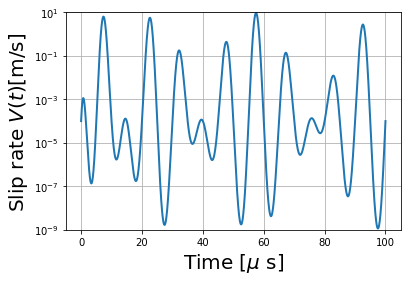

In [46]:
# Set V(t) [m/s]
T = 10. # [\mu s], minimal positive period
V = torch.pow(10., torch.ones(t.shape, dtype=torch.float64) * (-4.)  + \
              5. * torch.cos(2 * torch.pi * 0.2 * torch.sqrt(1.e6 * t)) * torch.sin(2 * torch.pi / T * 1.e6 * t))
plt.semilogy(1e6 * t, V, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('Slip rate $V(t) \mathrm{[m/s]}$', fontsize=20)
plt.ylim([1e-9, 10.])
plt.grid()
plt.show()

# Generate $\theta(t)$ and $\tau(t)$

In [47]:
# Call TimeSequenceGen
mySeq = TimeSequenceGen(t, N, V, myRSParams)

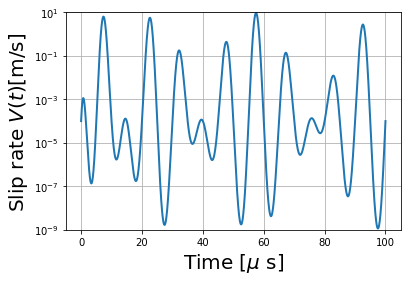

In [48]:
# Plot V(t)
plt.semilogy(1e6 * t, mySeq.Ds, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('Slip rate $V(t) \mathrm{[m/s]}$', fontsize=20)
plt.ylim([1e-9, 10.])
plt.grid()
plt.show()

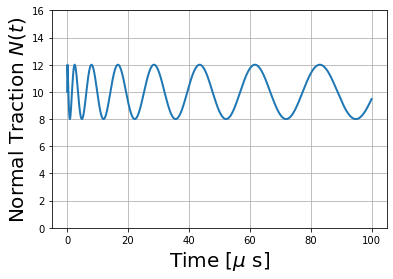

In [49]:
# Plot N(t)
plt.plot(1e6 * t, N, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('Normal Traction $N(t)$', fontsize=20)
plt.ylim([0, 16])
plt.grid()
plt.show()

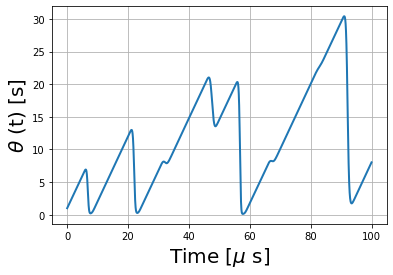

In [50]:
# Plot theta(t)
plt.plot(1e6 * mySeq.t, mySeq.theta, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('$\\theta$ (t) [s]', fontsize=20)
# plt.ylim([0, 16])
plt.grid()
plt.show()

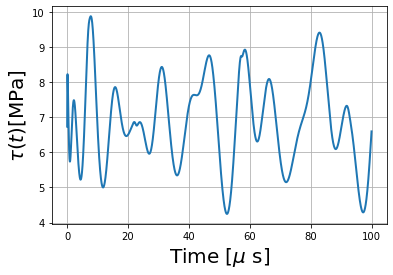

In [51]:
# Plot tau(t)
plt.plot(1e6 * mySeq.t, mySeq.tau, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('$\\tau(t) [\mathrm{MPa}]$', fontsize=20)
# plt.ylim([0, 16])
plt.grid()
plt.show()

# Generate training sequences in parallel

In [44]:
# Import joblibs
from joblib import Parallel, delayed, effective_n_jobs
print('Number of workers available: ', effective_n_jobs(-1))

Number of workers available:  36


In [73]:
# Specify number of sequences, number of Fourier terms in each N(t), V(t) sequence
N_seq = 10_000
N_grid_points = 10_000
n_Fourier = 8
T = 100.e-6    # |\mathcal{T}|
t = torch.linspace(0., T, N_grid_points, dtype = torch.float64)

# Pre-calculate sin(k pi/T t) and cos(k pi/T t)
K = torch.linspace(0, n_Fourier - 1, n_Fourier, dtype = torch.float64)
kPitOverT = K.reshape([-1, 1]) * torch.pi / T * t

# Generate N(t) sequences in MPa, N_seq times
NfSin = torch.rand([N_seq, n_Fourier], dtype = torch.float64) * 5.
NfCos = torch.rand([N_seq, n_Fourier], dtype = torch.float64) * 5.

# All N_seq normal tractions
NAll = torch.matmul(NfSin, torch.sin(kPitOverT)) + torch.matmul(NfCos, torch.cos(kPitOverT))

# Generate logV(t) sequences in m/s, N_seq times
VfSin = torch.rand([N_seq, n_Fourier], dtype = torch.float64)
VfCos = torch.rand([N_seq, n_Fourier], dtype = torch.float64)

# All N_seq normal tractions
VAll = torch.matmul(VfSin, torch.sin(kPitOverT)) + torch.matmul(VfCos, torch.cos(kPitOverT))
VAll = torch.pow(10., VAll)

In [74]:
NAll

tensor([[26.2491, 26.2722, 26.2952,  ..., -8.1403, -8.1439, -8.1475],
        [21.4977, 21.5241, 21.5504,  ...,  4.3585,  4.3595,  4.3604],
        [20.5945, 20.6199, 20.6453,  ...,  1.8855,  1.8839,  1.8823],
        ...,
        [17.1318, 17.1625, 17.1932,  ...,  2.5165,  2.5102,  2.5038],
        [22.7140, 22.7274, 22.7407,  ..., -1.1717, -1.1716, -1.1714],
        [23.7153, 23.7329, 23.7505,  ...,  1.9742,  1.9618,  1.9493]],
       dtype=torch.float64)

In [75]:
VAll

tensor([[3.2375e+03, 3.2640e+03, 3.2907e+03,  ..., 2.0739e-01, 2.0781e-01,
         2.0823e-01],
        [4.9157e+03, 4.9676e+03, 5.0201e+03,  ..., 1.4464e+00, 1.4405e+00,
         1.4347e+00],
        [2.9956e+04, 3.0237e+04, 3.0520e+04,  ..., 2.8002e+01, 2.7898e+01,
         2.7793e+01],
        ...,
        [1.7028e+04, 1.7164e+04, 1.7301e+04,  ..., 8.1686e-01, 8.1393e-01,
         8.1100e-01],
        [1.4341e+04, 1.4507e+04, 1.4674e+04,  ..., 5.8879e-01, 5.8914e-01,
         5.8950e-01],
        [7.3125e+01, 7.3956e+01, 7.4797e+01,  ..., 3.2797e-01, 3.2709e-01,
         3.2622e-01]], dtype=torch.float64)

In [62]:
a = torch.rand([3, 4])
b = torch.rand([4, 5])
c = torch.matmul(a, b)
c

tensor([[0.8201, 0.5355, 0.7456, 0.7745, 0.9657],
        [0.8657, 1.1765, 1.3275, 0.8298, 1.7104],
        [1.3557, 0.9854, 1.0627, 1.3678, 1.4301]])